In [1]:
import os
import tweepy as tw
import pandas as pd
import yaml

import re
import unicodedata
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

ModuleNotFoundError: No module named 'nltk'

# Step 1: Set up Twitter API access
Set up the project here: https://developer.twitter.com/en/portal/projects-and-apps

Using this site as reference: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/

In [ ]:
# Reference: https://gist.github.com/radcliff/47af9f6238c95f6ae239
# Load yml file to dictionary
credentials = yaml.load(open('./credentials.yml'), Loader=yaml.FullLoader)

# Define access keys and tokens
consumer_key = credentials['twitter_api']['consumer_key']
consumer_secret = credentials['twitter_api']['consumer_secret']
access_token = credentials['twitter_api']['access_token']
access_token_secret = credentials['twitter_api']['access_token_secret']

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit = True)

# Step 2: Get tweets and transform into dataframe

In [4]:
# Reference: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/

# define parameters for API request
search_word = "#covidcanada"
num_of_tweets = 1000
include_retweets = False
language = "en"

if include_retweets == False:
    search_word = search_word + " -filter:retweets"

tweets = tw.Cursor(api.search,
                    q=search_word,
                    tweet_mode = "extended",
                    lang=language).items(num_of_tweets)

In [5]:
# Twitter API data dictionary: https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet

# Get column names
api_colnames_call = api.search(q=search_word, count=num_of_tweets)
json_data = [c._json for c in api_colnames_call]

# create dataframe from JSON result
api_colnames = pd.json_normalize(json_data)

# print all column names
for col in api_colnames.columns:
    print(col)

created_at
id
id_str
text
truncated
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
geo
coordinates
place
contributors
is_quote_status
retweet_count
favorite_count
favorited
retweeted
possibly_sensitive
lang
entities.hashtags
entities.symbols
entities.user_mentions
entities.urls
metadata.iso_language_code
metadata.result_type
user.id
user.id_str
user.name
user.screen_name
user.location
user.description
user.url
user.entities.url.urls
user.entities.description.urls
user.protected
user.followers_count
user.friends_count
user.listed_count
user.created_at
user.favourites_count
user.utc_offset
user.time_zone
user.geo_enabled
user.verified
user.statuses_count
user.lang
user.contributors_enabled
user.is_translator
user.is_translation_enabled
user.profile_background_color
user.profile_background_image_url
user.profile_background_image_url_https
user.profile_background_tile
user.profile_image_url
user.profile_image_url_h

In [6]:
# Specify which columns to pull from API
tweet_metadata = [[tweet.created_at, tweet.id, tweet.full_text, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count] for tweet in tweets]

print(tweet_metadata[:2])

[[datetime.datetime(2021, 6, 4, 18, 20, 58), 1400880272963518465, "Today's coronavirus news: Toronto is opening more than 10,000 additional vaccination appointments for next week, and Ontario is again asking the federal government to strengthen border enforcement. https://t.co/fU8mLoabqg\n\n#vaccineTO #COVIDtoronto #COVID19ON #COVIDcanada https://t.co/fRchXR4dwx", 'torontodotcom', 0, 0], [datetime.datetime(2021, 6, 4, 17, 55, 16), 1400873802695733248, '👋 @CPHO_Canada @CMOH_Alberta @shandro \nMaybe you could check this out?  Please and thanks.\n\n#COVIDCanada \n#COVID19AB \n\n👇🇨🇦 https://t.co/17k5jp25vt', 'SamRafoss', 0, 1]]


In [7]:
df_tweets_raw = pd.DataFrame(data=tweet_metadata, columns=['created_at', 'id', 'full_text', 'user', 'rt_count', 'fav_count'])
df_tweets_raw.head()

,created_at,id,full_text,user,rt_count,fav_count
0,2021-06-04 18:20:58,1400880272963518465,Today's coronavirus news: Toronto is opening m...,torontodotcom,0,0
1,2021-06-04 17:55:16,1400873802695733248,👋 @CPHO_Canada @CMOH_Alberta @shandro \nMaybe ...,SamRafoss,0,1
2,2021-06-04 17:20:12,1400864980078006274,Excited to sit down for another @ProjectCanary...,crystalmundypsy,2,2
3,2021-06-04 17:00:19,1400859977040945155,This Roberta Place personal support worker was...,torontodotcom,3,4
4,2021-06-04 16:02:35,1400845447959351298,5 ways you can help end HIV &amp; AIDS\n.\n.\n...,INSTI,0,0


# Step 3: Exploratory data analysis (EDA)

In [8]:
print('Rows:', df_tweets_raw.shape[0], '\nColumns:', df_tweets_raw.shape[1])

Rows: 198 
Columns: 6


In [10]:
max_tweet_length = df_tweets_raw.full_text.apply(len).max()
print('Longest tweet is', max_tweet_length, 'characters long')

Longest tweet is 331 characters long


In [11]:
min_date = df_tweets_raw.created_at.min()
max_date = df_tweets_raw.created_at.max()

print('Min. date: ', min_date, '\nMax. date: ', max_date)

Min. date:  2021-05-27 17:01:16 
Max. date:  2021-06-04 18:20:58


In [11]:
df_tweets_raw.describe(include='all')

ipykernel_launcher:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,created_at,id,text,user,rt_count,fav_count
count,202,2.020000e+02,202,202,202.000000,202.000000
unique,201,NaN,202,56,NaN,NaN
top,2021-05-27 18:20:04,NaN,"Canada receiving 500,000 Moderna doses next we...",iChinadian,NaN,NaN
freq,2,NaN,1,65,NaN,NaN
first,2021-05-24 09:01:30,NaN,NaN,NaN,NaN,NaN
last,2021-06-01 02:33:01,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.398030e+18,NaN,NaN,0.435644,1.564356
std,NaN,7.600366e+14,NaN,NaN,1.082799,5.554642
min,NaN,1.396753e+18,NaN,NaN,0.000000,0.000000
25%,NaN,1.397374e+18,NaN,NaN,0.000000,0.000000


# Step 4: Clean data

Create a copy to preserve the raw data

In [12]:
df_tweets = df_tweets_raw.copy()

Sample tweets

In [13]:
df_tweets_raw.text[26]

'@5BobbyArmstrong @fordnation @Franktmcveety People that replied “F” should be Ashamed 😢 of Themselves. #CovidCanada… https://t.co/zox5lCuzbn'

In [14]:
# View more sample tweets
for i in range(0,5):
    print(str(i+1) + ') ' + df_tweets_raw.text[i] + '\n')

1) Great work done on picking up the COVID-19  population vaccinated in Canada! I am happy to see this progress.… https://t.co/4EEwVho4se

2) COVID-19 in B.C.: Vaccine error among youth; one new bloodclotting case; outbreak at one school; and more… https://t.co/w95icVuclI

3) COVID-19: More than three million British Columbians have now received vaccine https://t.co/2nbYEqqULv #COVIDBC… https://t.co/Q3AZMZf3av

4) Updated (May 31, 2021) summary of the #Canadian #COVID19 #pandemic based on @GovCanHealth data. #Canada has adminis… https://t.co/i9mzBEybEL

5) Active COVID-19 infections in B.C. fall to lowest level since November https://t.co/Bi9kRPwNBD via @viawesome… https://t.co/0acCgpT5un



## Step 4a: Convert tweets to lower case

In [15]:
# Convert transcripts to lower case
df_tweets['text_cleaned'] = df_tweets['full_text'].map(lambda x: x.lower())

In [16]:
df_tweets.text_cleaned[26]

'@5bobbyarmstrong @fordnation @franktmcveety people that replied “f” should be ashamed 😢 of themselves. #covidcanada… https://t.co/zox5lcuzbn'

## Step 4b: Remove custom stop words

In [17]:
# Remove tweet URLs
df_tweets['text_cleaned'] = df_tweets['text_cleaned'].map(lambda x: re.sub(r'https\:\/\/t\.co\/*\w*', '', x, flags=re.MULTILINE).strip())

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
@5bobbyarmstrong @fordnation @franktmcveety people that replied “f” should be ashamed 😢 of themselves. #covidcanada…


## Step 4c: Tokenize and lemmatize tweets
Tokenization parses tweets into individual words and lemmatization removes inflectional endings (ie. endings that add grammatical meaning). These methods prepare the data for word frequency and n-gram analysis.

Methods used below reference this post: https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460

In [18]:
def basic_clean(text):
    """
    A simple function to clean up the data. All the words that
    are not designated as a stop word is then lemmatized after
    encoding and basic regex parsing are performed.
    """
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore'))
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words = basic_clean(''.join(str(df_tweets['text_cleaned'].tolist())))
words[:15]

['great',
 'work',
 'done',
 'picking',
 'covid19',
 'population',
 'vaccinated',
 'canada',
 'happy',
 'see',
 'progress',
 'covid19',
 'bc',
 'vaccine',
 'error']

# Step 5: Analyze tweets

## Step 5a: Word frequencies and n-grams

In [20]:
def tweets_ngrams(n, top_n):
    result = (pd.Series(nltk.ngrams(words, n)).value_counts())[:top_n]
    return result

word_series = tweets_ngrams(1, 15)
bigram_series = tweets_ngrams(2, 15)
trigram_series = tweets_ngrams(3, 15)

bigram_series

(covid19, case)           17
(covid19, vaccine)        11
(2021, summary)            9
(canadian, covid19)        9
(covid19, pandemic)        9
(via, viawesome)           9
(govcanhealth, data)       9
(canada, adminis)          9
(based, govcanhealth)      9
(covidbc, covidcanada)     9
(updated, may)             9
(pandemic, based)          9
(data, canada)             9
(summary, canadian)        9
(new, covid19)             8
dtype: int64

In [21]:
#TODO: visualize word frequencies in horizontal bar charts

In [22]:
sns.set_style('whitegrid')
%matplotlib inline

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


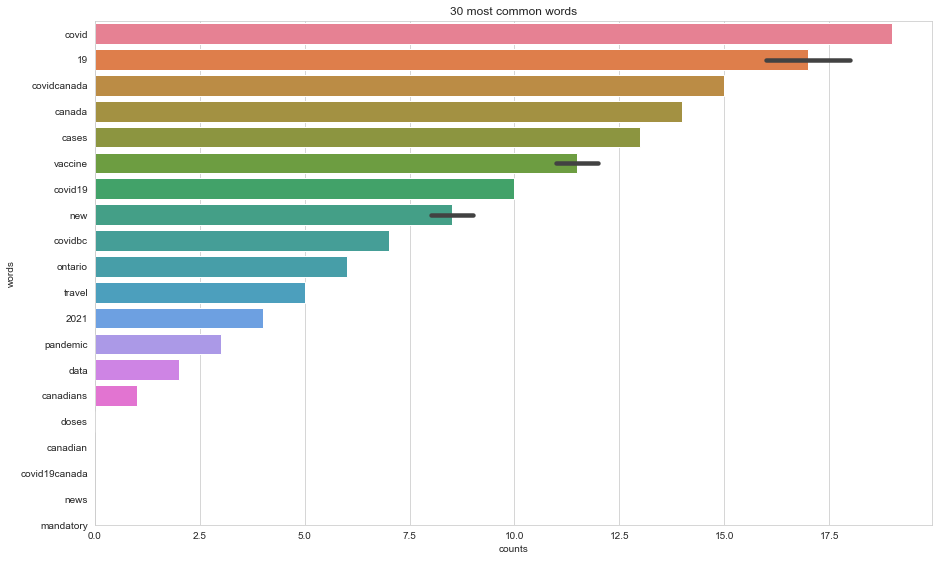

In [23]:
# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl', orient = 'h')
    plt.yticks(x_pos, words) 
    plt.ylabel('words')
    plt.xlabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed transcripts
count_data = count_vectorizer.fit_transform(df_tweets['text_cleaned'])

# Visualise the 30 most common words
plot_30_most_common_words(count_data, count_vectorizer)

## Step 5b: Sentiment analysis

In [24]:
#TODO: Dom to troubleshoot - why tweets are the same
# initialize list
new_df = []

for tweet in df_tweets['text_cleaned']:
    blob = TextBlob(str(tweet))
    score = {
        'full_text': df_tweets['full_text'],
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity
    }
    new_df.append(score)
    #print(score)

# turn the new_df 
test = pd.DataFrame(new_df)

# remove rows where polarity = 0.000
test = test[(test.polarity != 0.0000)]
print(test.head())

test.to_csv('data/sentiment_reviews.csv', index=False)

                                                text  polarity  subjectivity
0  0      Great work done on picking up the COVID...  0.900000      0.875000
1  0      Great work done on picking up the COVID...  0.136364      0.454545
2  0      Great work done on picking up the COVID...  0.250000      0.250000
4  0      Great work done on picking up the COVID... -0.133333      0.600000
5  0      Great work done on picking up the COVID...  0.500000      0.500000
